# Tests of the SC model

## Notation and model specs to complement what is in the model scoping doc

Value function for a predicted state $\mathbf{x}'$, reached by action $\mathbf{a}$:
* Speed-controlling agent: $V(\mathbf{x}', \mathbf{a}) = k_g v_g - k_c / \tau - k_{dv} v^2 - k_e \Delta v^2$
* Acceleration-controlling agent: $V(\mathbf{x}', \mathbf{a}) = k_g v - k_{sc} a_{sc}^2 - k_{sg} a_{sg}^2 - k_{dv} v^2 - k_{da} a^2 - k_e \Delta a^2$

where $v_g$ is the predicted rate of change of the distance to the goal, $\tau$ predicted time to collision with the other agent (infinite if no collision course), $v$ and $a$ are predicted longitudinal speed and acceleration (all predictions referring to the state $\mathbf{x}'$ after the prediction interval),  $\Delta v$ and $\Delta a$ are the changes in speed or acceleration effectuated by action $\mathbf{a}$, and $a_{sc}$ and $a_{sg}$ are accelerations required to stop just before collision and just before the goal, respectively; the rest above are model parameters.

To see what code variables relate to what model quantities, see comments on the lines initialising the `self.states` variables in `SCAgent.prepare_for_simulation()`.

Conflict between code and scoping doc:
- Code uses a parameter $\kappa$ in $^O A_b(t)$ update, not present in the model scoping doc

## Code verification Tests

### Two pedestrians

This is not exactly the same as any other scenario I have on record, because currently I am running with $\Delta T = T_P$ = 0.5 s, whereas I used 0.3 s in all my initial speed-control simulations. But it still behaves qualitatively the same.


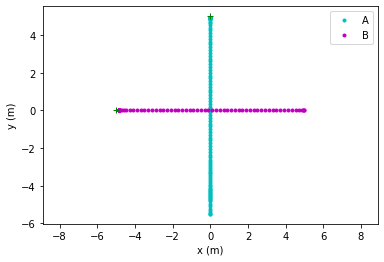

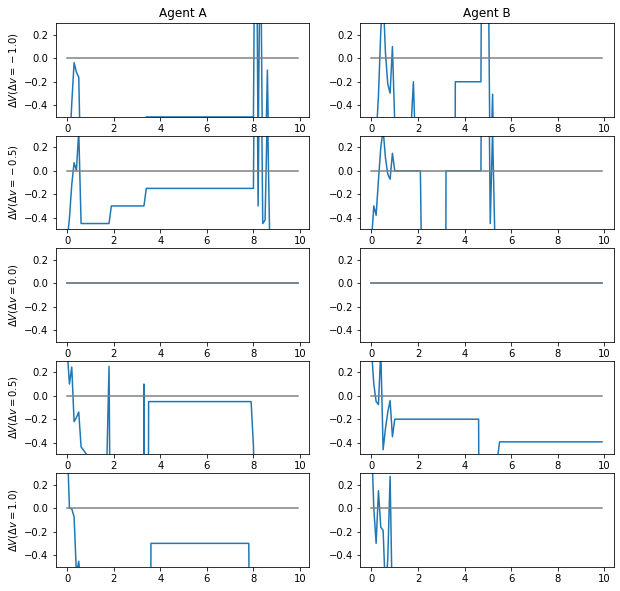

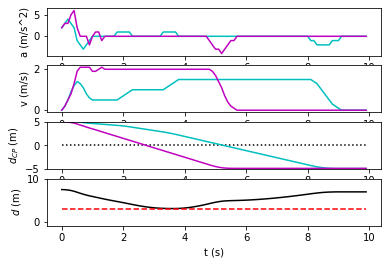

In [2]:
import numpy as np
import importlib
import commotions
import sc_scenario
importlib.reload(sc_scenario)
from sc_scenario import CtrlType

CTRL_TYPES = (CtrlType.SPEED, CtrlType.SPEED)
INITIAL_POSITIONS = np.array([[0,-5.5], [5, 0]])
GOALS = np.array([[0, 5], [-5, 0]])
optional_assumptions = sc_scenario.get_assumptions_dict(default_value = False)

sc_simulation = sc_scenario.SCSimulation(CTRL_TYPES, GOALS, INITIAL_POSITIONS, \
    optional_assumptions = optional_assumptions)
sc_simulation.run()
sc_simulation.do_plots(trajs = True, surplus_action_vals = True, kinem_states = True)

### Two cars

Recreating the two-car simulation in "acceleration ctrl tests" - verifying the implementation here by confirming that I get the same result as with that simpler implementation, when running with all optional assumptions disabled.

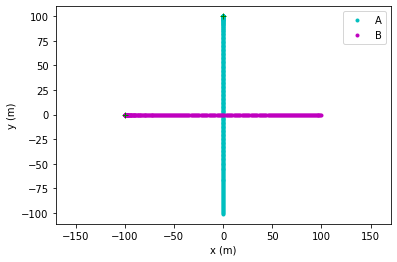

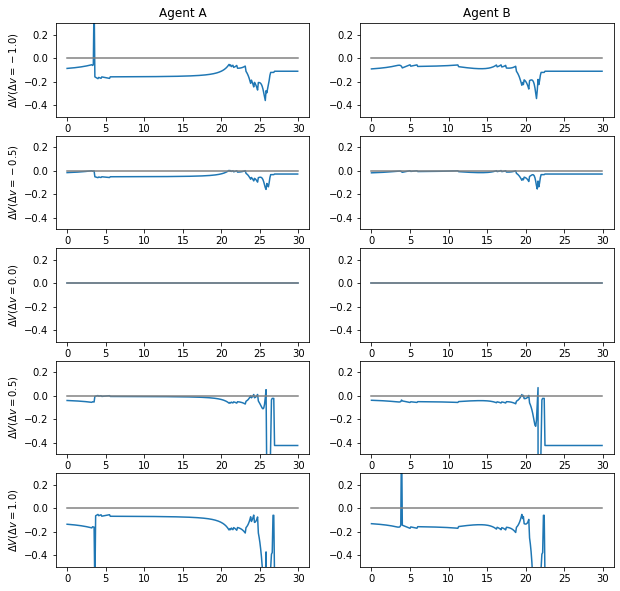

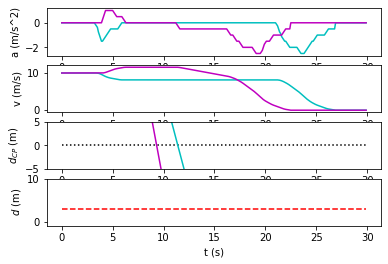

In [3]:
import numpy as np
import importlib
import commotions
import sc_scenario
importlib.reload(sc_scenario)
from sc_scenario import CtrlType

CTRL_TYPES = (CtrlType.ACCELERATION, CtrlType.ACCELERATION)
INITIAL_POSITIONS = np.array([[0,-101], [100, 0]])
GOALS = np.array([[0, 100], [-100, 0]])
SPEEDS = np.array((10, 10))
optional_assumptions = sc_scenario.get_assumptions_dict(default_value = False)

sc_simulation = sc_scenario.SCSimulation(CTRL_TYPES, GOALS, INITIAL_POSITIONS, \
    initial_speeds = SPEEDS, end_time = 30, optional_assumptions = optional_assumptions)
sc_simulation.run()
sc_simulation.do_plots(trajs = True, surplus_action_vals = True, kinem_states = True)

### Car and pedestrian

And a similar code verification for the car-pedestrian simulation, by disabling all optional assumptions. Again, I am getting the same results as in "acceleration ctrl tests".

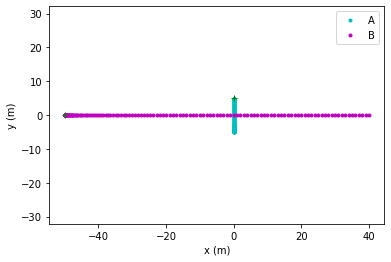

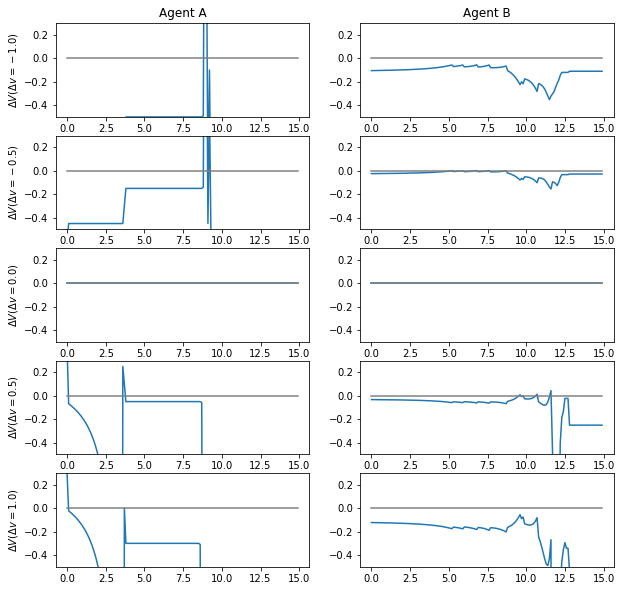

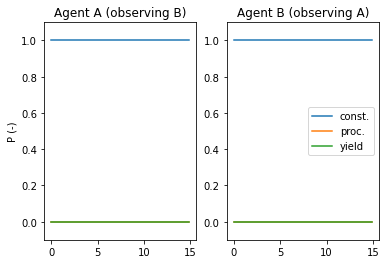

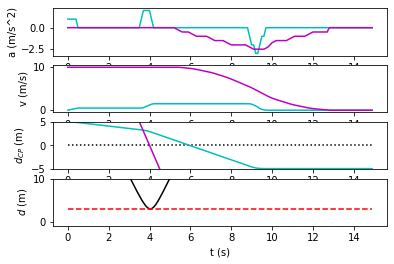

In [17]:
import numpy as np
import importlib
import commotions
import sc_scenario
importlib.reload(sc_scenario)
from sc_scenario import CtrlType

CTRL_TYPES = (CtrlType.SPEED, CtrlType.ACCELERATION) 
INITIAL_POSITIONS = np.array([[0,-5], [40, 0]])
GOALS = np.array([[0, 5], [-50, 0]])
SPEEDS = np.array((0, 10))
optional_assumptions = sc_scenario.get_assumptions_dict(default_value = False)
 
sc_simulation = sc_scenario.SCSimulation(CTRL_TYPES, GOALS, INITIAL_POSITIONS, \
    initial_speeds = SPEEDS, end_time = 15, optional_assumptions = optional_assumptions)
sc_simulation.run()
sc_simulation.do_plots(trajs = True, surplus_action_vals = True, kinem_states = True, beh_probs = True)

## Evidence accumulation without noise

Testing now to take the same scenario as just above, and turning on the evidence accumulation assumption (`oEA`). As might be expected, this does not change behaviour much, mostly just only introduces slight delays/smoothing of behaviour. But note that it does change the nature of the car's deceleration to stop somewhat (becomes a sort of rolling stop), and it changes the free flowing speed of the pedestrian, since the final increase in speed from 1 m/s to 1.5 m/s in this parameterisation happens to end up just below the $\Delta V_{th} = 0.1$ threshold.

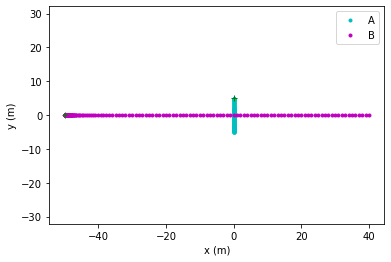

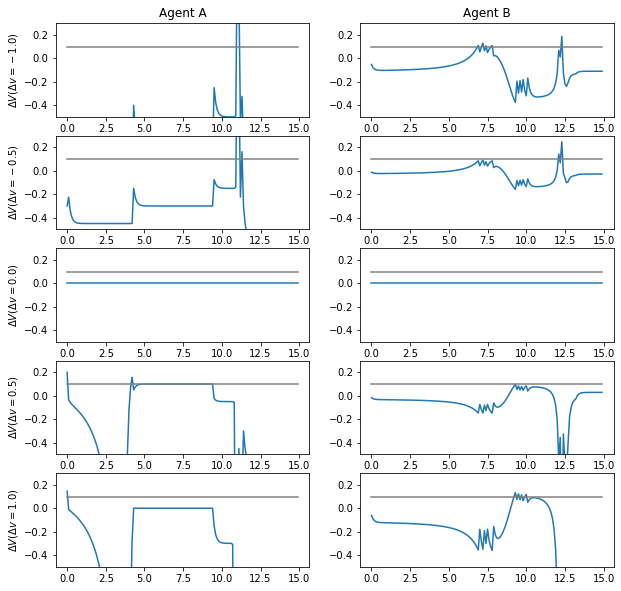

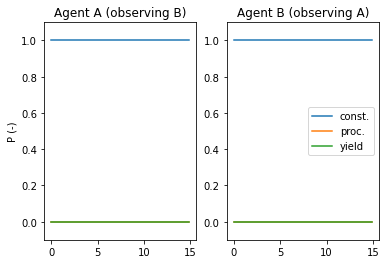

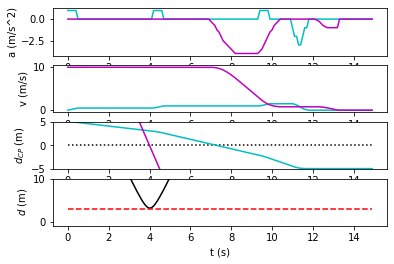

In [11]:
import numpy as np
import importlib
import commotions
import sc_scenario
importlib.reload(sc_scenario)
from sc_scenario import CtrlType

CTRL_TYPES = (CtrlType.SPEED, CtrlType.ACCELERATION) # need to redefine this one after the importlib.reload - causes weird bugs otherwise, presumably because CtrlType has been redefined
optional_assumptions = sc_scenario.get_assumptions_dict(default_value = False, oEA = True)

sc_simulation = sc_scenario.SCSimulation(CTRL_TYPES, GOALS, INITIAL_POSITIONS, \
    initial_speeds = SPEEDS, end_time = 15, optional_assumptions = optional_assumptions)
sc_simulation.run()
sc_simulation.do_plots(trajs = True, surplus_action_vals = True, kinem_states = True, beh_probs = True)


## Behaviour estimation by action observation
Now, again for the same base scenario, testing just turning on the behaviour estimation by action observation assumption (`oBEAao`). Note that the car now first decelerates a bit, but then converges on thinking that the pedestrian is yielding (which it is), and thus stops decelerating at about 2 s, instead proceeding ahead. However, the car still has some lingering uncertainty about whether the pedestrian might actually choose to proceed (accelerate toward its free flowing speed), and this seems to cause some wild acceleration/deceleration between 2 s and 4 s of the simulation, essentially cancelling out to constant speed. The last deceleration action just before passing the pedestrian is left uncancelled however, causing the car to keep slowing down a bit until about 7 s (the $\Delta a$ = +0.5 m/s$^2$ action just rises above the 0.1 threshold value a few times during this interval - more visible in the $\Delta a$ = +1 m/s$^2$ action surplus value subplot).

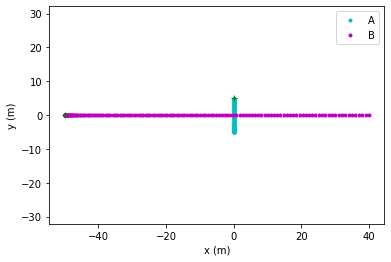

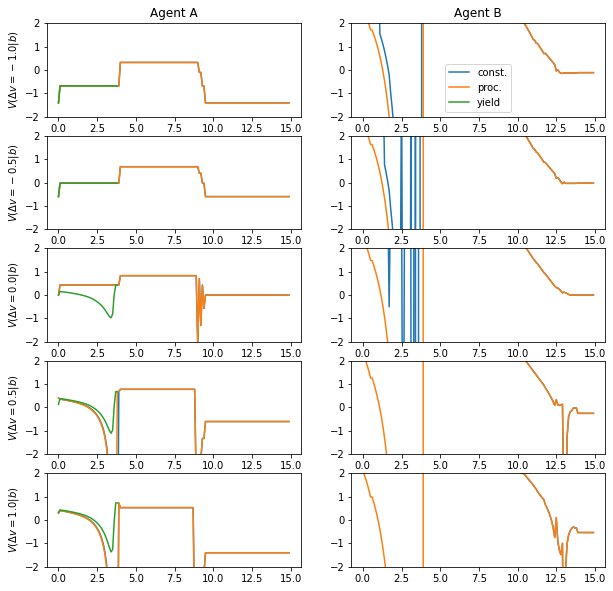

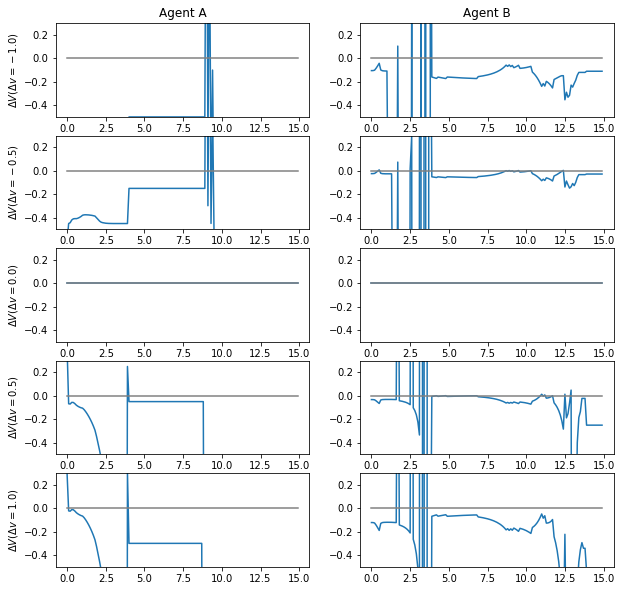

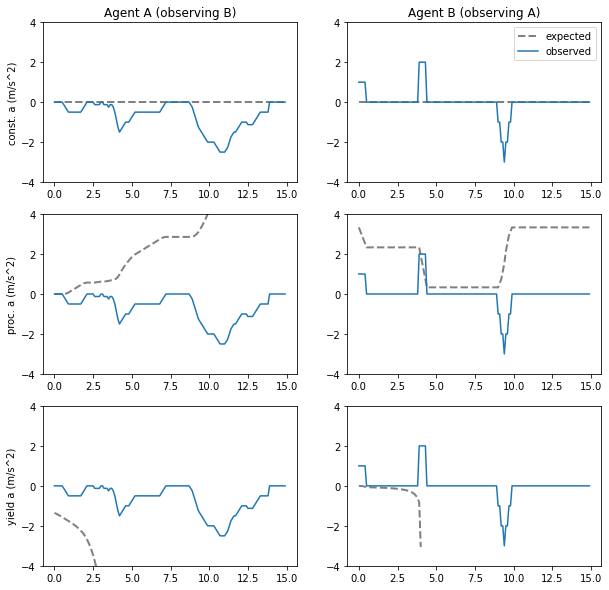

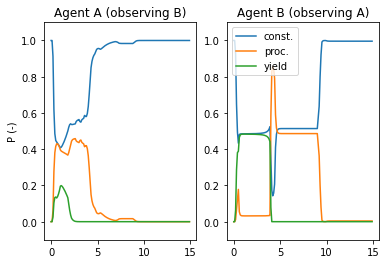

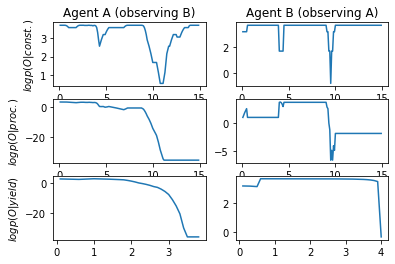

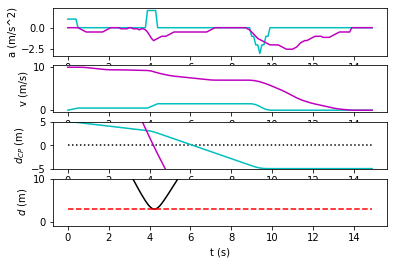

In [19]:
import numpy as np
import importlib
import commotions
import sc_scenario
importlib.reload(sc_scenario)
from sc_scenario import CtrlType

CTRL_TYPES = (CtrlType.SPEED, CtrlType.ACCELERATION) # need to redefine this one after the importlib.reload - causes weird bugs otherwise, presumably because CtrlType has been redefined
optional_assumptions = sc_scenario.get_assumptions_dict(default_value = False, oBEao = True)

sc_simulation = sc_scenario.SCSimulation(CTRL_TYPES, GOALS, INITIAL_POSITIONS, \
    initial_speeds = SPEEDS, end_time = 15, optional_assumptions = optional_assumptions)
sc_simulation.run()
sc_simulation.do_plots(trajs = True, surplus_action_vals = True, kinem_states = True, \
    sensory_prob_dens = True, beh_probs = True, action_vals = True, beh_accs = True)

Another interesting case, decreasing the initial TTA to 2 s, first here simulated without the `oBEao` assumption. As expected the car just proceeds and the pedestrian adapts speed to pass behind.

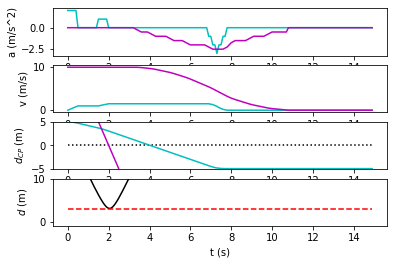

In [22]:
import numpy as np
import importlib
import commotions
import sc_scenario
importlib.reload(sc_scenario)
from sc_scenario import CtrlType

CTRL_TYPES = (CtrlType.SPEED, CtrlType.ACCELERATION) # need to redefine this one after the importlib.reload - causes weird bugs otherwise, presumably because CtrlType has been redefined
INITIAL_POSITIONS = np.array([[0,-5], [20, 0]])
optional_assumptions = sc_scenario.get_assumptions_dict(default_value = False, oBEao = False)

sc_simulation = sc_scenario.SCSimulation(CTRL_TYPES, GOALS, INITIAL_POSITIONS, \
    initial_speeds = SPEEDS, end_time = 15, optional_assumptions = optional_assumptions)
sc_simulation.run()
sc_simulation.do_plots(kinem_states = True)

And then with `oBEao` turned on. Now, there is an oscillation between the agents where they misinterpret each other. The car first (at <1 s) mistakes the pedestrian's initial small acceleration for a "proceeding" toward free flow speed, so it decelerates, causing the pedestrian to infer that the car is yielding (at about 1.5-2 s). The car then realizes that the pedestrian wasn't proceeding (at about 2 s), so stabilizes at a new constant but lower speed (2-3 s), which the pedestrian makes use of by increasing speed to pass close behind the car, causing the car to again worry that the pedestrian is proceeding toward free speed (at about 3 s), causing another deceleration.

This is possibly realistic to some extent, but obviously the model shouldn't be too prone to this type of miscommunicaiton. I think part of the problem here could be that the yielding acceleration is currently calculated only as the acceleration needed to stop in front of the conflict space, not to just pass smoothly behind.

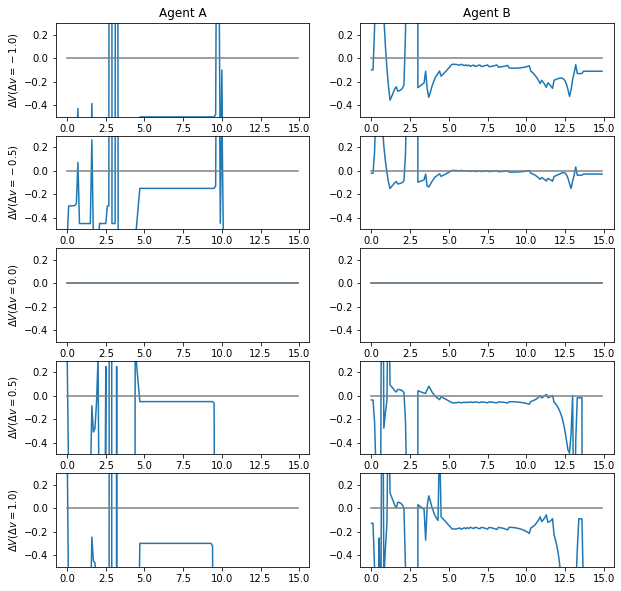

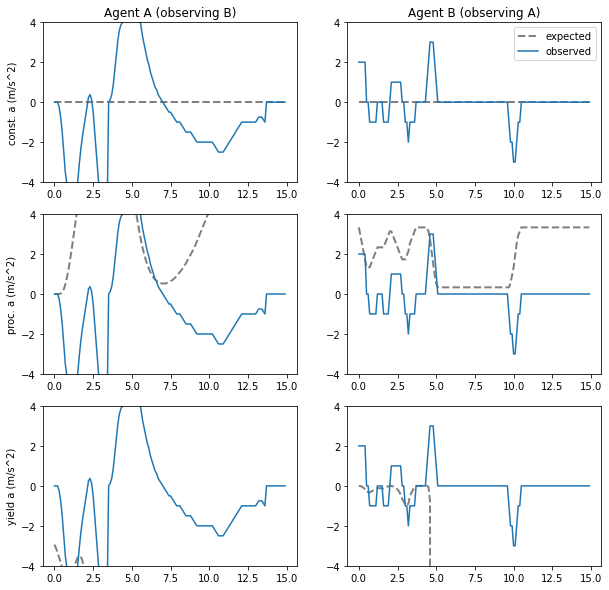

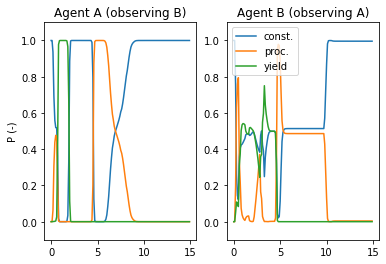

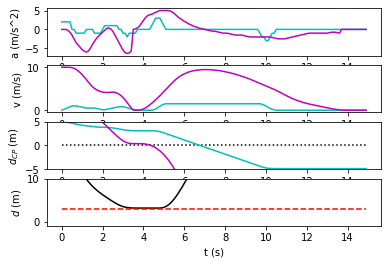

In [25]:
import numpy as np
import importlib
import commotions
import sc_scenario
importlib.reload(sc_scenario)
from sc_scenario import CtrlType

CTRL_TYPES = (CtrlType.SPEED, CtrlType.ACCELERATION) # need to redefine this one after the importlib.reload - causes weird bugs otherwise, presumably because CtrlType has been redefined
optional_assumptions = sc_scenario.get_assumptions_dict(default_value = False, oBEao = True)

sc_simulation = sc_scenario.SCSimulation(CTRL_TYPES, GOALS, INITIAL_POSITIONS, \
    initial_speeds = SPEEDS, end_time = 15, optional_assumptions = optional_assumptions)
sc_simulation.run()
sc_simulation.do_plots(surplus_action_vals = True, kinem_states = True, beh_probs = True, beh_accs = True)